In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


### Summary

SUMMARY OF LEVELS REGRESSIONS ACROSS FORECAST HORIZONS
Model    lasso  ridge
Horizon              
1        0.605  0.538
2        0.402  0.495
3        0.225  0.274
4        0.345  0.312
5        0.367  0.366



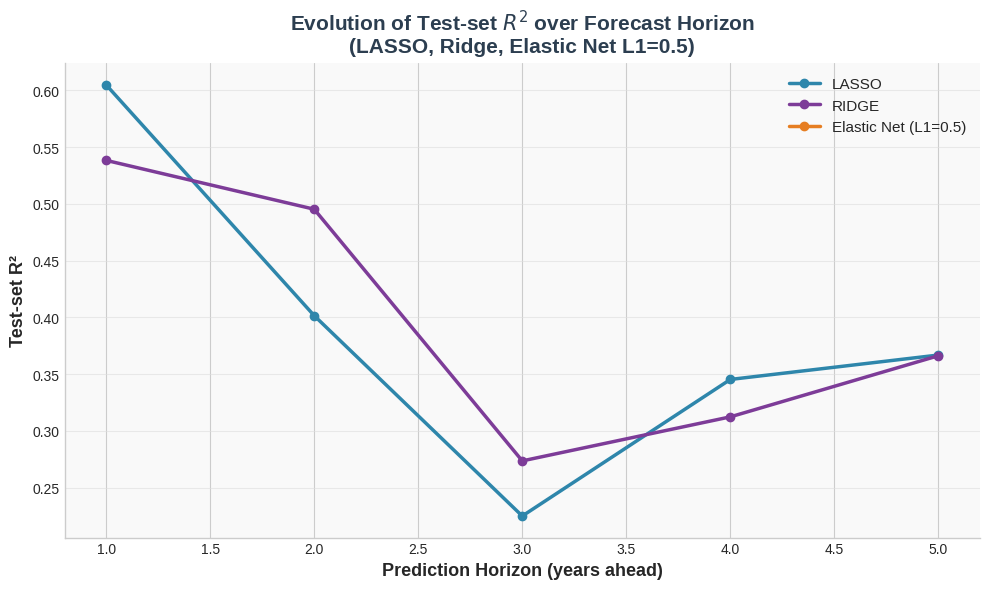

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

specs_dir = "specs"
base_name = "levels"
suffix = "_agn_clust"
horizons = range(1, 11)
models_to_plot = {
    "lasso": "LASSO",
    "ridge": "RIDGE",
    "elastic_l1_0.5": "Elastic Net (L1=0.5)"
}

summary_data = []

# Loop through horizons and load results
for h in horizons:
    target_prefix = f"{base_name}_t{h}"
    for model_type in ["lasso", "ridge", "elastic"]:
        if model_type == "elastic":
            l1_ratio = 0.5
            fname = f"{model_type}_{target_prefix}{suffix}_l1_{l1_ratio}_results.dat"
            label = f"elastic_l1_{l1_ratio}"
        else:
            fname = f"{model_type}_{target_prefix}{suffix}_results.dat"
            label = model_type

        fpath = os.path.join(specs_dir, fname)
        if not os.path.exists(fpath):
            continue

        df = pd.read_pickle(fpath)
        best_idx = df['R²_test'].idxmax()
        best_row = df.iloc[best_idx]
        summary_data.append({
            "Horizon": h,
            "Model": label,
            "R²_test": best_row['R²_test'],
            "R²_train": best_row['R²_train'],
            "RMSE_test": best_row['RMSE_test']
        })

# Create summary dataframe
summary_df = pd.DataFrame(summary_data)
summary_df.sort_values(["Model", "Horizon"], inplace=True)

print("="*90)
print("SUMMARY OF LEVELS REGRESSIONS ACROSS FORECAST HORIZONS")
print("="*90)
print(summary_df.pivot(index="Horizon", columns="Model", values="R²_test").round(3))
print()

# Filter for relevant models
plot_df = summary_df[summary_df["Model"].isin(models_to_plot.keys())]

# Prepare plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

colors = {
    "lasso": "#2E86AB",
    "ridge": "#7D3C98",
    "elastic_l1_0.5": "#E67E22"
}

for key, display_name in models_to_plot.items():
    subset = plot_df[plot_df["Model"] == key]
    plt.plot(subset["Horizon"], subset["R²_test"], marker="o", linewidth=2.5,
             label=display_name, color=colors.get(key, "gray"))

ax.set_facecolor("#f9f9f9")
ax.set_xlabel("Prediction Horizon (years ahead)", fontsize=13, fontweight='bold')
ax.set_ylabel("Test-set R²", fontsize=13, fontweight='bold')
ax.set_title("Evolution of Test-set $R^2$ over Forecast Horizon\n(LASSO, Ridge, Elastic Net L1=0.5)",
             fontsize=15, fontweight='bold', pad=8, color="#2c3e50")
ax.legend(frameon=False, fontsize=11)
ax.grid(True, which="major", axis="y", color="#dddddd", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
import glob
print(glob.glob("specs/*results.dat"))

### Function

In [26]:
import os, time
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from IPython.display import display
from joblib import Parallel, delayed
import shap
import warnings

def filter_cols(cols, exclude_endings):
    return [c for c in cols if not any(c.endswith(ending) for ending in exclude_endings)]

def _yearwise_splits(years, min_train_years=8, stride=2):
    ys = np.asarray(years)
    uniq = np.sort(np.unique(ys))
    for k in range(min_train_years, len(uniq), stride):
        train = np.where(np.isin(ys, uniq[:k]))[0]
        val = np.where(ys == uniq[k])[0]
        yield train, val

def _rmse_for_param(param, X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2):
    rmse = []
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=2000, tol=1e-3, warm_start=False)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    for tr, va in _yearwise_splits(years, min_train_years, stride):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[va])
        rmse.append(np.sqrt(mean_squared_error(y.iloc[va], pred)))
    return param, float(np.mean(rmse)) if rmse else np.inf

def choose_param_expanding_fast(X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2, n_jobs=-1):
    if model_type == 'lasso':
        alphas = np.logspace(-4, 1, 20)
        cv_folds = []
        for tr, va in _yearwise_splits(years, min_train_years, stride):
            cv_folds.append((tr, va))

        if len(cv_folds) > 0:
            lasso_cv = LassoCV(alphas=alphas, cv=cv_folds, max_iter=2000, tol=1e-3, n_jobs=n_jobs)
            lasso_cv.fit(X, y)
            return lasso_cv.alpha_

    elif model_type == 'elastic':
        alphas = np.logspace(-4, 1, 20)
        cv_folds = []
        for tr, va in _yearwise_splits(years, min_train_years, stride):
            cv_folds.append((tr, va))

        if len(cv_folds) > 0:
            elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=[l1_ratio], cv=cv_folds,
                                    max_iter=2000, tol=1e-3, n_jobs=n_jobs)
            elastic_cv.fit(X, y)
            return elastic_cv.alpha_

    params_coarse = np.logspace(0, 5, 15) if model_type == 'ridge' else np.logspace(-4, 1, 12)
    coarse = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(params_coarse, reverse=True)
    )
    p0 = min(coarse, key=lambda t: t[1])[0]
    low, high = p0/5, p0*5
    fine_grid = np.logspace(np.log10(low), np.log10(high), 8)
    fine = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(fine_grid, reverse=True)
    )
    return min(fine, key=lambda t: t[1])[0]

def _fit_model_for_factor(factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                         y_train, y_test, spread_train, spread_test, model_type, l1_ratio, agnostic):
    param = optimal_param * factor
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=2000, tol=1e-3)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)

    model.fit(X_train, y_train_adj)
    y_pred_test_adj = model.predict(X_test)
    y_pred_train_adj = model.predict(X_train)

    if not agnostic:
        y_pred_test = spread_test + y_pred_test_adj
        y_pred_train = spread_train + y_pred_train_adj
    else:
        y_pred_test = y_pred_test_adj
        y_pred_train = y_pred_train_adj

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    active_vars = np.sum(model.coef_ != 0)

    if not agnostic:
        e_benchmark = y_test - spread_test
        e_model = y_test - y_pred_test
        dm_stat, dm_p = _dm_test(e_benchmark, e_model)
    else:
        dm_stat, dm_p = np.nan, np.nan

    return {
        'factor': factor,
        'param': param,
        'R²_train': r2_train,
        'R²_test': r2_test,
        'RMSE_test': rmse_test,
        'Active_vars': active_vars,
        'DM_stat': dm_stat,
        'DM_p': dm_p,
        'model': model,
        'predictions': y_pred_test
    }

def _dm_test(e0, e1):
    d = e0**2 - e1**2
    T = len(d)
    v = np.var(d, ddof=1)
    if T < 2 or v == 0 or np.isnan(v):
        return np.nan, np.nan
    stat = d.mean() / np.sqrt(v / T)
    pval = 2 * (1 - norm.cdf(abs(stat)))
    return stat, pval

def cluster_features(X_train, y_train=None, corr_threshold=0.75, method='complete'):
    def extract_core(var):
        suffixes = ['_delta3', '_delta', '_t-5', '_t-3', '_t-2', '_t-1', '_ma10', '_ma5', '_ma3']
        for s in suffixes:
            if var.endswith(s):
                return var[:-len(s)]
        return var

    core_groups = {}
    for v in X_train.columns:
        core = extract_core(v)
        core_groups.setdefault(core, []).append(v)

    cluster_map = {}
    representative_vars = []
    cluster_id = 0
    cluster_records = []

    for core, vars_in_core in core_groups.items():
        if len(vars_in_core) == 1:
            cluster_id += 1
            var = vars_in_core[0]
            cluster_map[cluster_id] = [var]
            representative_vars.append(var)
            cluster_records.append({'variable': var, 'cluster': cluster_id})
            continue

        corr_matrix = X_train[vars_in_core].corr().abs()
        distance_matrix = 1 - corr_matrix
        condensed_dist = squareform(distance_matrix, checks=False)
        linkage_matrix = linkage(condensed_dist, method=method)
        clusters = fcluster(linkage_matrix, t=1 - corr_threshold, criterion='distance')

        for subcluster_id in np.unique(clusters):
            cluster_id += 1
            cluster_vars = [vars_in_core[i] for i, c in enumerate(clusters) if c == subcluster_id]
            cluster_map[cluster_id] = cluster_vars

            if y_train is not None:
                corrs = X_train[cluster_vars].corrwith(y_train)
                rep_var = corrs.abs().idxmax()
            else:
                variances = X_train[cluster_vars].var()
                rep_var = variances.idxmax()

            representative_vars.append(rep_var)
            for v in cluster_vars:
                cluster_records.append({'variable': v, 'cluster': cluster_id})

    cluster_df = pd.DataFrame(cluster_records)
    return representative_vars, cluster_map, cluster_df

def extract_core_variable(var_name):
    suffixes = ['_delta3', '_delta', '_t-5', '_t-4', '_t-3', '_t-2', '_t-1',
                '_ma10', '_ma5', '_ma3']
    for suffix in suffixes:
        if var_name.endswith(suffix):
            return var_name[:-len(suffix)]
    return var_name

def aggregate_by_core_variable(importance_df):
    importance_df = importance_df.copy()
    importance_df['core_variable'] = importance_df['variable'].apply(extract_core_variable)

    agg_dict = {'variable': lambda x: list(x)}

    if 'shap_importance' in importance_df.columns:
        agg_dict['shap_importance'] = 'sum'
    if 'shap_importance_pct' in importance_df.columns:
        agg_dict['shap_importance_pct'] = 'sum'
    if 'selection_frequency' in importance_df.columns:
        agg_dict['selection_frequency'] = 'mean'
    if 'mean_coef' in importance_df.columns:
        agg_dict['mean_coef'] = 'mean'
    if 'std_coef' in importance_df.columns:
        agg_dict['std_coef'] = 'mean'

    core_agg = importance_df.groupby('core_variable').agg(agg_dict).reset_index()
    core_agg['n_variants'] = core_agg['variable'].apply(len)
    core_agg = core_agg.rename(columns={'variable': 'variants'})

    if 'shap_importance' in core_agg.columns:
        core_agg = core_agg.sort_values('shap_importance', key=abs, ascending=False)
    elif 'selection_frequency' in core_agg.columns:
        core_agg = core_agg.sort_values('selection_frequency', ascending=False)

    return core_agg

def identify_cross_variable_correlations(X, threshold=0.75):
    var_to_core = {var: extract_core_variable(var) for var in X.columns}

    corr_matrix = X.corr().abs()

    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]

            core1 = var_to_core[var1]
            core2 = var_to_core[var2]

            if core1 != core2 and corr_val > threshold:
                high_corr_pairs.append({
                    'core_variable_1': core1,
                    'core_variable_2': core2,
                    'correlation': corr_val
                })

    if not high_corr_pairs:
        return pd.DataFrame()

    pairs_df = pd.DataFrame(high_corr_pairs)

    pairs_df['pair'] = pairs_df.apply(
        lambda row: tuple(sorted([row['core_variable_1'], row['core_variable_2']])),
        axis=1
    )

    result = pairs_df.loc[pairs_df.groupby('pair')['correlation'].idxmax()].copy()
    result = result[['core_variable_1', 'core_variable_2', 'correlation']].sort_values('correlation', ascending=False)
    result = result.reset_index(drop=True)

    return result

def calculate_shap_importance(model, X_test, max_samples=500):
    X_sample = X_test if len(X_test) <= max_samples else X_test.sample(max_samples, random_state=42)

    if hasattr(model, 'coef_'):
        explainer = shap.LinearExplainer(model, X_sample)
    else:
        explainer = shap.Explainer(model.predict, X_sample)

    shap_values = explainer(X_sample)

    if hasattr(shap_values, 'values'):
        shap_vals = shap_values.values
    else:
        shap_vals = shap_values

    mean_abs_shap = np.abs(shap_vals).mean(axis=0)

    shap_df = pd.DataFrame({
        'variable': X_test.columns,
        'shap_importance': mean_abs_shap,
        'shap_importance_pct': mean_abs_shap / mean_abs_shap.sum() * 100
    }).sort_values('shap_importance', ascending=False)

    return shap_df, shap_values

def stability_selection(X_train, y_train, model_type='lasso', alpha=None, l1_ratio=0.5,
                       n_iterations=100, subsample_frac=0.8, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X_train)
    subsample_size = int(n_samples * subsample_frac)

    selection_counts = {col: 0 for col in X_train.columns}
    coef_values = {col: [] for col in X_train.columns}

    for i in range(n_iterations):
        idx = np.random.choice(n_samples, size=subsample_size, replace=False)
        X_sub = X_train.iloc[idx]
        y_sub = y_train.iloc[idx]

        if model_type == 'lasso':
            if alpha is None:
                model = LassoCV(max_iter=2000, tol=1e-3, n_jobs=-1, random_state=random_state+i)
            else:
                model = Lasso(alpha=alpha, max_iter=2000, tol=1e-3)
        elif model_type == 'elastic':
            if alpha is None:
                model = ElasticNetCV(l1_ratio=l1_ratio, max_iter=2000, tol=1e-3, n_jobs=-1, random_state=random_state+i)
            else:
                model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
        elif model_type == 'ridge':
            model = Ridge(alpha=alpha if alpha else 1.0)

        model.fit(X_sub, y_sub)

        for col, coef in zip(X_train.columns, model.coef_):
            if coef != 0:
                selection_counts[col] += 1
                coef_values[col].append(coef)

    stability_df = pd.DataFrame({
        'variable': X_train.columns,
        'selection_frequency': [selection_counts[col] / n_iterations for col in X_train.columns],
        'mean_coef': [np.mean(coef_values[col]) if coef_values[col] else 0 for col in X_train.columns],
        'std_coef': [np.std(coef_values[col]) if coef_values[col] else 0 for col in X_train.columns],
        'n_selections': [selection_counts[col] for col in X_train.columns]
    }).sort_values('selection_frequency', ascending=False)

    stability_df['stable'] = stability_df['selection_frequency'] >= 0.8

    return stability_df

def run_unified_regularized_regression(
    name_prefix="base",
    data_path="saved/df.dat",
    macro_cols=None,
    iq_cols=None,
    y_name="tgt_spread",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['lasso', 'ridge', 'elastic'],
    agnostic=True,
    param_factors=[0.5, 1.0, 2.0],
    l1_ratios=[0.5],
    use_clustering=True,
    corr_threshold=0.85,
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=None,
    rmse_benchmark=None,
    early_stop_threshold=0.10,
    stability_iterations=100,
    save_results=True,
    output_dir="specs",
    n_jobs=-1,
    parallel_param_factors=True,
    compute_shap=True,
    max_shap_samples=500,
    force_interpretability=False,
    r2_convergence_threshold=1e-4,
    r2_convergence_count=3,
    multicollinearity_check=True,
):
    print(f"\n{'='*80}")
    print(f"UNIFIED REGULARIZED REGRESSION: {name_prefix.upper()}")
    print(f"Specification: {'Agnostic (β unrestricted)' if agnostic else 'β=1 (fixed at mean reversion)'}")
    print(f"Models: {', '.join([m.upper() for m in model_types])}")
    if 'elastic' in model_types:
        print(f"Elastic Net L1 ratios: {l1_ratios}")
    if use_clustering:
        print(f"Feature clustering: ON (threshold={corr_threshold})")
    print(f"Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)")
    print(f"R² convergence: Stop after {r2_convergence_count} consecutive changes < {r2_convergence_threshold}")
    if force_interpretability:
        print("Force interpretability: ON (interpret even if DM test fails)")
    print(f"{'='*80}\n")
    start_time = time.time()

    df = pd.read_pickle(data_path)
    df = df[df[y_name].notna()]
    df[year_col] = df[year_col].astype(int)

    if macro_cols is None:
        macro_cols = []
    if iq_cols is None:
        iq_cols = []

    train_data = df[df[year_col] <= split_year].copy()
    test_data = df[df[year_col] > split_year].copy()

    print(f"Train: {train_data[year_col].min()}-{train_data[year_col].max()} ({len(train_data)} obs)")
    print(f"Test:  {test_data[year_col].min()}-{test_data[year_col].max()} ({len(test_data)} obs)\n")

    feature_cols = macro_cols + iq_cols
    if spread_col in feature_cols and not agnostic:
        feature_cols = [c for c in feature_cols if c != spread_col]

    X_train_raw = train_data[feature_cols].copy()
    X_test_raw = test_data[feature_cols].copy()
    y_train = train_data[y_name].copy()
    y_test = test_data[y_name].copy()
    years_train = train_data[year_col].values

    if not agnostic:
        if spread_col not in train_data.columns:
            raise ValueError(f"β=1 specification requires '{spread_col}' column")
        spread_train = train_data[spread_col].copy()
        spread_test = test_data[spread_col].copy()
        mask_train = spread_train.notna() & y_train.notna()
        mask_test = spread_test.notna() & y_test.notna()
        X_train_raw = X_train_raw.loc[mask_train]
        X_test_raw = X_test_raw.loc[mask_test]
        y_train = y_train.loc[mask_train]
        y_test = y_test.loc[mask_test]
        spread_train = spread_train.loc[mask_train]
        spread_test = spread_test.loc[mask_test]
        years_train = years_train[mask_train.values]
        y_train_adj = y_train - spread_train
        y_test_adj = y_test - spread_test
        print(f"β=1 specification: predicting (spread_t+1 - spread_t)")
        print(f"After removing NaN: {len(y_train_adj)} train, {len(y_test_adj)} test obs\n")
    else:
        y_train_adj = y_train
        y_test_adj = y_test
        spread_train = None
        spread_test = None

    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train_raw)
    X_test_imp = imputer.transform(X_test_raw)
    X_train_imp_df = pd.DataFrame(X_train_imp, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test_imp_df = pd.DataFrame(X_test_imp, index=X_test_raw.index, columns=X_test_raw.columns)

    if multicollinearity_check:
        print(f"{'='*80}")
        print("MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)")
        print(f"{'='*80}\n")

        cross_corr = identify_cross_variable_correlations(X_train_imp_df, threshold=corr_threshold)
        if len(cross_corr) > 0:
            print(f"Found {len(cross_corr)} core variable pairs with correlation above {corr_threshold}:\n")
            display(cross_corr.head(20))
            print("\nNote: These correlations are reported for transparency.")
            print("Regularization handles multicollinearity. Interpretation focuses on stable patterns.\n")
        else:
            print(f"No cross-core-variable correlations above {corr_threshold} threshold.\n")

    if use_clustering:
        print("Clustering variants of same variables...")
        representative_vars, cluster_map, cluster_df = cluster_features(X_train_imp_df, y_train_adj, corr_threshold=corr_threshold)
        print(f"  Original features: {len(X_train_imp_df.columns)}")
        print(f"  After clustering: {len(representative_vars)}")
        print(f"  Number of clusters: {len(cluster_map)}\n")
        X_train_clustered = X_train_imp_df[representative_vars]
        X_test_clustered = X_test_imp_df[representative_vars]
    else:
        X_train_clustered = X_train_imp_df
        X_test_clustered = X_test_imp_df
        cluster_map = {i: [col] for i, col in enumerate(X_train_imp_df.columns)}
        cluster_df = pd.DataFrame({'variable': X_train_imp_df.columns, 'cluster': range(len(X_train_imp_df.columns))})

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train_clustered), index=X_train_clustered.index, columns=X_train_clustered.columns)
    X_test = pd.DataFrame(scaler.transform(X_test_clustered), index=X_test_clustered.index, columns=X_test_clustered.columns)
    feature_names = list(X_train.columns)
    print(f"Features used in models: {len(feature_names)}\n")

    all_results = {}

    for model_type in model_types:
        if model_type == 'elastic':
            for l1_ratio in l1_ratios:
                model_name = f"{model_type}_l1_{l1_ratio}"
                print(f"\n{'-'*80}")
                print(f"RUNNING {model_type.upper()} (L1 ratio={l1_ratio})")
                print(f"{'-'*80}\n")

                if use_expanding_cv:
                    print("Selecting optimal parameter via expanding window CV...")
                    optimal_param = choose_param_expanding_fast(X_train, y_train_adj, years_train,
                                                               model_type=model_type, l1_ratio=l1_ratio,
                                                               min_train_years=min_train_years,
                                                               stride=cv_stride, n_jobs=n_jobs)
                else:
                    params = np.logspace(-4, 1, 20)
                    best_score = -np.inf
                    optimal_param = params[0]
                    for p in params:
                        m = ElasticNet(alpha=p, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
                        m.fit(X_train, y_train_adj)
                        score = m.score(X_train, y_train_adj)
                        if score > best_score:
                            best_score = score
                            optimal_param = p
                print(f"Optimal parameter: {optimal_param:.6f}\n")

                results_rows = []
                models = {}
                r2_history = []
                convergence_counter = 0

                for factor in param_factors:
                    result = _fit_model_for_factor(
                        factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                        y_train, y_test, spread_train, spread_test, model_type, l1_ratio, agnostic
                    )

                    if result['Active_vars'] == 0:
                        print(f"Stopping: model has 0 active variables at factor {factor}\n")
                        break

                    results_rows.append({k: v for k, v in result.items() if k not in ['model', 'predictions']})
                    if 'l1_ratio' not in results_rows[-1]:
                        results_rows[-1]['l1_ratio'] = l1_ratio
                    models[result['factor']] = (result['model'], result['predictions'])

                    # Check R² convergence
                    r2_test = result['R²_test']
                    if len(r2_history) > 0:
                        r2_change = abs(r2_test - r2_history[-1])
                        if r2_change < r2_convergence_threshold:
                            convergence_counter += 1
                            print(f"Factor {factor}: R² change = {r2_change:.6f} (convergence count: {convergence_counter}/{r2_convergence_count})")
                        else:
                            convergence_counter = 0

                        if convergence_counter >= r2_convergence_count:
                            print(f"Early stopping: R² converged (change < {r2_convergence_threshold} for {r2_convergence_count} consecutive factors)\n")
                            break

                    r2_history.append(r2_test)

                if not results_rows:
                    print(f"No valid results for {model_name}, skipping...\n")
                    continue

                results_df = pd.DataFrame(results_rows)
                display(results_df)

                best_idx = results_df['R²_test'].idxmax()
                best_row = results_df.iloc[best_idx]
                best_model, best_pred = models[best_row['factor']]

                print(f"\nBest {model_type.upper()} (L1={l1_ratio}):")
                print(f"  Parameter: {best_row['param']:.6f}")
                print(f"  R² (test): {best_row['R²_test']:.4f}")
                print(f"  RMSE (test): {best_row['RMSE_test']:.4f}")
                print(f"  Active vars: {int(best_row['Active_vars'])}")
                if r2_benchmark is not None:
                    print(f"  ΔR² vs benchmark: {(best_row['R²_test'] - r2_benchmark)*100:+.2f} p.p.")
                if rmse_benchmark is not None:
                    print(f"  ΔRMSE vs benchmark: {(best_row['RMSE_test'] - rmse_benchmark):+.4f}")
                if not agnostic:
                    print(f"  DM test: stat={best_row['DM_stat']:.2f}, p={best_row['DM_p']:.3f}")

                # ALWAYS SAVE MAIN RESULTS
                if save_results:
                    os.makedirs(output_dir, exist_ok=True)
                    suffix = f"{'_agn' if agnostic else ''}_l1_{l1_ratio}{'_clust' if use_clustering else ''}"
                    results_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_results.dat")
                    pd.Series(best_model.coef_, index=feature_names).to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_coefs.dat")
                    if use_clustering:
                        cluster_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_clusters.dat")

                should_skip_interpretability = False
                skip_reason = None

                if int(best_row['Active_vars']) == 0:
                    should_skip_interpretability = True
                    skip_reason = "model has 0 active variables"
                elif not agnostic and not force_interpretability:
                    if np.isnan(best_row['DM_p']) or best_row['DM_p'] >= 0.05:
                        should_skip_interpretability = True
                        skip_reason = f"no significant incremental value over mean reversion benchmark (DM p={best_row['DM_p']:.3f})"

                if should_skip_interpretability:
                    print(f"\nSkipping interpretability analysis: {skip_reason}\n")
                    if not agnostic:
                        print("Interpretation: Macro/IQ variables do not provide statistically significant")
                        print("incremental predictive power beyond the mean reversion benchmark.\n")
                    all_results[model_name] = {
                        'results_df': results_df,
                        'best_model': best_model,
                        'best_row': best_row,
                        'predictions': best_pred,
                        'l1_ratio': l1_ratio,
                        'skipped_interpretability': True,
                        'skip_reason': skip_reason
                    }
                    continue

                print(f"\n{'='*80}")
                if agnostic:
                    print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?")
                else:
                    print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?")
                print(f"({model_type.upper()}, L1={l1_ratio})")
                print(f"{'='*80}\n")

                print(f"{'='*80}")
                print(f"METHOD 1: SHAP VALUES (Feature Attribution)")
                print(f"{'='*80}\n")

                shap_df, core_shap = None, None
                if compute_shap:
                    try:
                        print("Computing SHAP values...")
                        shap_df, shap_values = calculate_shap_importance(best_model, X_test, max_samples=max_shap_samples)

                        core_shap = aggregate_by_core_variable(shap_df)
                        core_shap_nonzero = core_shap[core_shap['shap_importance'] > 1e-6].copy()
                        if len(core_shap_nonzero) > 0:
                            print(f"\nTop {min(20, len(core_shap_nonzero))} core variables by SHAP importance:\n")
                            display(core_shap_nonzero.head(20))
                        else:
                            print("\nNo core variables with meaningful SHAP importance\n")
                    except Exception as e:
                        print(f"SHAP computation failed: {str(e)}")
                        print("Skipping SHAP analysis...\n")

                print(f"\n{'='*80}")
                print(f"METHOD 2: STABILITY SELECTION")
                print(f"{'='*80}\n")

                print(f"Running stability selection ({stability_iterations} iterations)...")
                stability = stability_selection(
                    X_train, y_train_adj,
                    model_type=model_type,
                    alpha=best_row['param'],
                    l1_ratio=l1_ratio,
                    n_iterations=stability_iterations
                )

                stability_stable = stability[stability['stable']].copy()
                if len(stability_stable) > 0:
                    core_stability = aggregate_by_core_variable(stability_stable)
                    print(f"\nCore variables with stable variants (aggregated from {len(stability_stable)} stable features):\n")
                    display(core_stability.head(20))
                else:
                    print("No variables meet stability criterion (80% selection frequency)\n")
                    core_stability = pd.DataFrame()

                if save_results:
                    suffix = f"{'_agn' if agnostic else ''}_l1_{l1_ratio}{'_clust' if use_clustering else ''}"
                    if shap_df is not None:
                        shap_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_shap.dat")
                        core_shap.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_shap.dat")
                    stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_stability.dat")
                    if len(core_stability) > 0:
                        core_stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_stability.dat")

                all_results[model_name] = {
                    'results_df': results_df,
                    'best_model': best_model,
                    'best_row': best_row,
                    'shap_importance': shap_df,
                    'core_shap': core_shap,
                    'stability_selection': stability,
                    'core_stability': core_stability,
                    'cross_correlations': cross_corr if multicollinearity_check else None,
                    'cluster_map': cluster_map,
                    'predictions': best_pred,
                    'l1_ratio': l1_ratio
                }

        else:
            print(f"\n{'-'*80}")
            print(f"RUNNING {model_type.upper()}")
            print(f"{'-'*80}\n")

            if use_expanding_cv:
                print("Selecting optimal parameter via expanding window CV...")
                optimal_param = choose_param_expanding_fast(X_train, y_train_adj, years_train,
                                                           model_type=model_type, l1_ratio=0.5,
                                                           min_train_years=min_train_years,
                                                           stride=cv_stride, n_jobs=n_jobs)
            else:
                params = np.logspace(0, 5, 20) if model_type == 'ridge' else np.logspace(-4, 1, 20)
                best_score = -np.inf
                optimal_param = params[0]
                for p in params:
                    if model_type == 'lasso':
                        m = Lasso(alpha=p, max_iter=2000, tol=1e-3)
                    elif model_type == 'ridge':
                        m = Ridge(alpha=p)
                    m.fit(X_train, y_train_adj)
                    score = m.score(X_train, y_train_adj)
                    if score > best_score:
                        best_score = score
                        optimal_param = p
            print(f"Optimal parameter: {optimal_param:.6f}\n")

            results_rows = []
            models = {}
            r2_history = []
            convergence_counter = 0

            for factor in param_factors:
                result = _fit_model_for_factor(
                    factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                    y_train, y_test, spread_train, spread_test, model_type, 0.5, agnostic
                )

                if result['Active_vars'] == 0 and model_type == 'lasso':
                    print(f"Stopping: model has 0 active variables at factor {factor}\n")
                    break

                results_rows.append({k: v for k, v in result.items() if k not in ['model', 'predictions']})
                models[result['factor']] = (result['model'], result['predictions'])

                # Check R² convergence
                r2_test = result['R²_test']
                if len(r2_history) > 0:
                    r2_change = abs(r2_test - r2_history[-1])
                    if r2_change < r2_convergence_threshold:
                        convergence_counter += 1
                        print(f"Factor {factor}: R² change = {r2_change:.6f} (convergence count: {convergence_counter}/{r2_convergence_count})")
                    else:
                        convergence_counter = 0

                    if convergence_counter >= r2_convergence_count:
                        print(f"Early stopping: R² converged (change < {r2_convergence_threshold} for {r2_convergence_count} consecutive factors)\n")
                        break

                r2_history.append(r2_test)

            if not results_rows:
                print(f"No valid results for {model_type}, skipping...\n")
                continue

            results_df = pd.DataFrame(results_rows)
            display(results_df)

            best_idx = results_df['R²_test'].idxmax()
            best_row = results_df.iloc[best_idx]
            best_model, best_pred = models[best_row['factor']]

            print(f"\nBest {model_type.upper()}:")
            print(f"  Parameter: {best_row['param']:.6f}")
            print(f"  R² (test): {best_row['R²_test']:.4f}")
            print(f"  RMSE (test): {best_row['RMSE_test']:.4f}")
            print(f"  Active vars: {int(best_row['Active_vars'])}")
            if r2_benchmark is not None:
                print(f"  ΔR² vs benchmark: {(best_row['R²_test'] - r2_benchmark)*100:+.2f} p.p.")
            if rmse_benchmark is not None:
                print(f"  ΔRMSE vs benchmark: {(best_row['RMSE_test'] - rmse_benchmark):+.4f}")
            if not agnostic:
                print(f"  DM test: stat={best_row['DM_stat']:.2f}, p={best_row['DM_p']:.3f}")

            # ALWAYS SAVE MAIN RESULTS
            if save_results:
                os.makedirs(output_dir, exist_ok=True)
                suffix = f"{'_agn' if agnostic else ''}{'_clust' if use_clustering else ''}"
                results_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_results.dat")
                pd.Series(best_model.coef_, index=feature_names).to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_coefs.dat")
                if use_clustering:
                    cluster_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_clusters.dat")

            should_skip_interpretability = False
            skip_reason = None

            if model_type == 'lasso' and int(best_row['Active_vars']) == 0:
                should_skip_interpretability = True
                skip_reason = "model has 0 active variables"
            elif not agnostic and not force_interpretability:
                if np.isnan(best_row['DM_p']) or best_row['DM_p'] >= 0.05:
                    should_skip_interpretability = True
                    skip_reason = f"no significant incremental value over mean reversion benchmark (DM p={best_row['DM_p']:.3f})"

            if should_skip_interpretability:
                print(f"\nSkipping interpretability analysis: {skip_reason}\n")
                if not agnostic:
                    print("Interpretation: Macro/IQ variables do not provide statistically significant")
                    print("incremental predictive power beyond the mean reversion benchmark.\n")
                all_results[model_type] = {
                    'results_df': results_df,
                    'best_model': best_model,
                    'best_row': best_row,
                    'predictions': best_pred,
                    'skipped_interpretability': True,
                    'skip_reason': skip_reason
                }
                continue

            print(f"\n{'='*80}")
            if agnostic:
                print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?")
            else:
                print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?")
            print(f"({model_type.upper()})")
            print(f"{'='*80}\n")

            print(f"{'='*80}")
            print(f"METHOD 1: SHAP VALUES (Feature Attribution)")
            print(f"{'='*80}\n")

            shap_df, core_shap = None, None
            if compute_shap:
                try:
                    print("Computing SHAP values...")
                    shap_df, shap_values = calculate_shap_importance(best_model, X_test, max_samples=max_shap_samples)

                    core_shap = aggregate_by_core_variable(shap_df)
                    core_shap_nonzero = core_shap[core_shap['shap_importance'] > 1e-6].copy()
                    if len(core_shap_nonzero) > 0:
                        print(f"\nTop {min(20, len(core_shap_nonzero))} core variables by SHAP importance:\n")
                        display(core_shap_nonzero.head(20))
                    else:
                        print("\nNo core variables with meaningful SHAP importance\n")
                except Exception as e:
                    print(f"SHAP computation failed: {str(e)}")
                    print("Skipping SHAP analysis...\n")

            if model_type == 'ridge':
                print(f"\n{'='*80}")
                print(f"METHOD 2: STABILITY SELECTION")
                print(f"{'='*80}\n")
                print(f"Skipping stability selection for Ridge regression.")
                print("Ridge does not perform variable selection - all features have non-zero coefficients.")
                print("For feature importance with Ridge, refer to SHAP values above.\n")
                stability = None
                core_stability = None
            else:
                print(f"\n{'='*80}")
                print(f"METHOD 2: STABILITY SELECTION")
                print(f"{'='*80}\n")

                print(f"Running stability selection ({stability_iterations} iterations)...")
                stability = stability_selection(
                    X_train, y_train_adj,
                    model_type=model_type,
                    alpha=best_row['param'],
                    l1_ratio=0.5,
                    n_iterations=stability_iterations
                )

                stability_stable = stability[stability['stable']].copy()
                if len(stability_stable) > 0:
                    core_stability = aggregate_by_core_variable(stability_stable)
                    print(f"\nCore variables with stable variants (aggregated from {len(stability_stable)} stable features):\n")
                    display(core_stability.head(20))
                else:
                    print("No variables meet stability criterion (80% selection frequency)\n")
                    core_stability = pd.DataFrame()

            if save_results:
                suffix = f"{'_agn' if agnostic else ''}{'_clust' if use_clustering else ''}"
                if shap_df is not None:
                    shap_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_shap.dat")
                    core_shap.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_shap.dat")
                if stability is not None:
                    stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_stability.dat")
                    if core_stability is not None and len(core_stability) > 0:
                        core_stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_stability.dat")

            all_results[model_type] = {
                'results_df': results_df,
                'best_model': best_model,
                'best_row': best_row,
                'shap_importance': shap_df,
                'core_shap': core_shap,
                'stability_selection': stability,
                'core_stability': core_stability,
                'cross_correlations': cross_corr if multicollinearity_check else None,
                'cluster_map': cluster_map,
                'predictions': best_pred
            }

    elapsed = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"COMPLETED IN {elapsed:.1f}s")
    print(f"{'='*80}\n")
    return all_results

### Mean-reversion benchmark

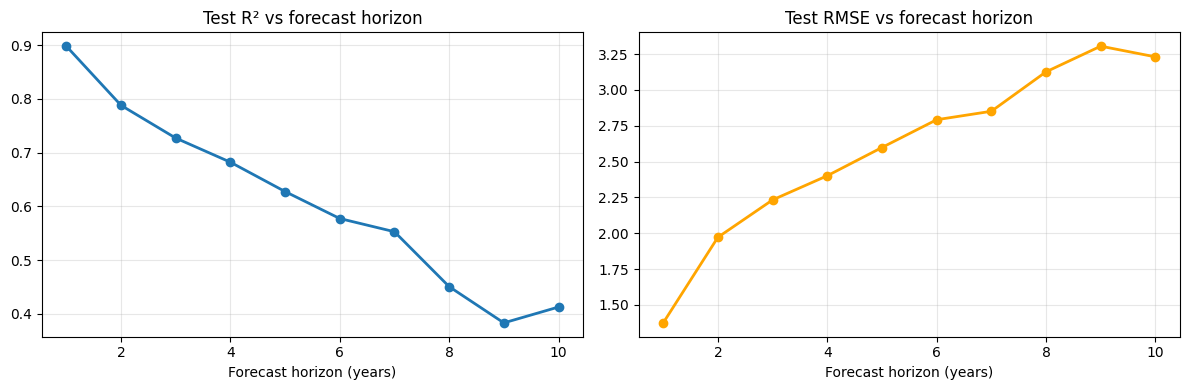

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_pickle("saved/df.dat")

base_cols = ["country", "year", "tgt_spread_t1", "tgt_spread"]
base_data = df[base_cols].dropna()
test_year = 2015
base = base_data[base_data["year"] >= test_year]

results = []
for horizon in range(1, 11):
    col = f"tgt_spread_t{horizon}"
    cols_needed = ["country", "year", "tgt_spread", col]
    fullte = df[cols_needed].dropna()

    cutoff_year = test_year - horizon
    fullte = fullte[fullte["year"] >= cutoff_year]

    if len(fullte) > 0:
        y_true = fullte[col]
        y_pred = fullte["tgt_spread"]

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        results.append({"horizon": horizon, "rmse": rmse, "r2": r2})

results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
axes[0].plot(results_df["horizon"], results_df["r2"], marker="o", lw=2)
axes[0].set_xlabel("Forecast horizon (years)")
axes[0].set_title("Test R² vs forecast horizon")
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_df["horizon"], results_df["rmse"], marker="o", lw=2, color="orange")
axes[1].set_xlabel("Forecast horizon (years)")
axes[1].set_title("Test RMSE vs forecast horizon")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Prediction

In [27]:
# Load
df = pd.read_pickle("saved/df.dat")

# Define
id_cols = ["country","year","iso_code_1","iso_code_2","region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = filter_cols([c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude], [])
iq_cols = filter_cols([c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))], [])
base_split_year = 2015
max_horizon = 10
all_horizon_results = {}

# For years 1 to 10
for h in range(1, max_horizon + 1):
    y_name = f"tgt_spread_t{h}"
    split_year = base_split_year - (h - 1)
    name_prefix = f"levels_t{h}"
    print("="*100)
    print(f"Horizon: t+{h}, Target: {y_name}, Split year: {split_year}")
    print("="*100)

    # Run the unified regression
    results = run_unified_regularized_regression(
        name_prefix=name_prefix,
        data_path="saved/df.dat",
        macro_cols=macro_cols,
        iq_cols=iq_cols,
        use_clustering=True,
        corr_threshold=0.9,
        y_name=y_name,
        spread_col="tgt_spread",
        year_col="year",
        split_year=split_year,
        model_types=['lasso','ridge','elastic'],
        agnostic=True,
        param_factors=np.logspace(-2,5,15),
        l1_ratios=[0.5],
        use_expanding_cv=True,
        min_train_years=8,
        cv_stride=2,
        r2_benchmark=None,
        rmse_benchmark=None,
        early_stop_threshold=0.10,
        save_results=True,
        output_dir="specs",
        n_jobs=-1,
        multicollinearity_check=False
    )
    all_horizon_results[f"t{h}"] = results

print("All horizon models completed.")

Horizon: t+1, Target: tgt_spread_t1, Split year: 2015

UNIFIED REGULARIZED REGRESSION: LEVELS_T1
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2015 (1706 obs)
Test:  2016-2023 (477 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 642
  Number of clusters: 642

Features used in models: 642


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 2.976351

Stopping: model has 0 active variables at factor 3.1622776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.029764,0.908379,0.604951,2.532100,238,NaN,NaN
1,0.031623,0.094120,0.850081,0.599103,2.550773,129,NaN,NaN
2,0.100000,0.297635,0.717521,0.508734,2.823670,26,NaN,NaN
3,0.316228,0.941205,0.432991,0.336384,3.281814,9,NaN,NaN
4,1.000000,2.976351,0.109805,-0.043245,4.114800,1,NaN,NaN



Best LASSO:
  Parameter: 0.029764
  R² (test): 0.6050
  RMSE (test): 2.5321
  Active vars: 238

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
17,efw_3_sound_money,"[efw_3_sound_money, efw_3_sound_money_t-1, efw...",1.470509,6.057769,7
20,efw_3d_foreign_currency_bank_accounts,"[efw_3d_foreign_currency_bank_accounts, efw_3d...",1.183252,4.874413,7
74,ief_monetary_freedom,"[ief_monetary_freedom_ma3, ief_monetary_freedo...",0.961210,3.959709,7
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies, efw_1b_transf...",0.884069,3.641925,6
21,efw_4_freedom_to_trade_internationally,"[efw_4_freedom_to_trade_internationally_t-5, e...",0.781912,3.221090,7
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-5, efw_2a_judi...",0.764883,3.150938,5
50,efw_5cii_bureacracy_costs,"[efw_5cii_bureacracy_costs_ma10, efw_5cii_bure...",0.745552,3.071303,8
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_ma10, ...",0.637396,2.625755,8
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.575095,2.369106,9
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.520598,2.144607,6



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 112 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
34,efw_5cii_bureacracy_costs,"[efw_5cii_bureacracy_costs_t-3, efw_5cii_burea...",1.000,0.034645,0.060173,2
33,efw_5ci_regulatory_burden,"[efw_5ci_regulatory_burden_t-3, efw_5ci_regula...",1.000,0.167402,0.047185,2
22,efw_4dii_capital_controls,[efw_4dii_capital_controls_ma10],1.000,0.320738,0.083045,1
35,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma10],1.000,-0.448522,0.149168,1
8,efw_2f_contracts,[efw_2f_contracts_delta3],1.000,-0.313034,0.047887,1
66,wb_tx_val_fuel_zs_un,[wb_tx_val_fuel_zs_un_ma3],1.000,0.221778,0.069568,1
21,efw_4di_financial_openness,[efw_4di_financial_openness_t-5],1.000,-0.310871,0.073683,1
49,ief_tax_burden,[ief_tax_burden_delta3],1.000,-0.107242,0.038975,1
44,ief_business_freedom,[ief_business_freedom_t-3],1.000,0.293092,0.086606,1
64,wb_ny_gdp_petr_rt_zs,[wb_ny_gdp_petr_rt_zs_delta],0.990,-0.274407,0.093990,1



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 2961.936296



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,2.961936e+01,0.926626,0.320358,3.321206,642,NaN,NaN
1,0.031623,9.366465e+01,0.888355,0.341136,3.270043,642,NaN,NaN
2,0.100000,2.961936e+02,0.807519,0.323546,3.313408,642,NaN,NaN
3,0.316228,9.366465e+02,0.687296,0.379173,3.174249,642,NaN,NaN
4,1.000000,2.961936e+03,0.559092,0.497286,2.856380,642,NaN,NaN
5,3.162278,9.366465e+03,0.427728,0.538405,2.737071,642,NaN,NaN
6,10.000000,2.961936e+04,0.293871,0.499814,2.849191,642,NaN,NaN
7,31.622777,9.366465e+04,0.186258,0.420857,3.065833,642,NaN,NaN
8,100.000000,2.961936e+05,0.106612,0.279418,3.419773,642,NaN,NaN
9,316.227766,9.366465e+05,0.048488,0.112276,3.795724,642,NaN,NaN



Best RIDGE:
  Parameter: 9366.464980
  R² (test): 0.5384
  RMSE (test): 2.7371
  Active vars: 642

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.688200,8.106141,9
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.279316,3.289997,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.264399,3.114287,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.242151,2.852240,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-3...,0.230030,2.709467,7
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.196067,2.309422,5
74,ief_monetary_freedom,"[ief_monetary_freedom, ief_monetary_freedom_ma...",0.189873,2.236462,7
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_t-1, efw_5aii_...",0.171220,2.016758,8
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.169454,1.995960,5
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_t-3, wb_iq_spi_pil1_delta3, wb...",0.169098,1.991760,7



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 2.976351

Stopping: model has 0 active variables at factor 3.1622776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p,l1_ratio
0,0.010000,0.029764,0.908687,0.513314,2.810476,357,NaN,NaN,0.5
1,0.031623,0.094120,0.842477,0.545704,2.715347,235,NaN,NaN,0.5
2,0.100000,0.297635,0.671206,0.436706,3.023593,113,NaN,NaN,0.5
3,0.316228,0.941205,0.482193,0.391085,3.143649,47,NaN,NaN,0.5
4,1.000000,2.976351,0.267906,0.197804,3.608245,22,NaN,NaN,0.5



Best ELASTIC (L1=0.5):
  Parameter: 0.094120
  R² (test): 0.5457
  RMSE (test): 2.7153
  Active vars: 235

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC, L1=0.5)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",1.698177,8.398655,9
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-5, efw_2a_judi...",0.996769,4.929710,5
74,ief_monetary_freedom,"[ief_monetary_freedom_ma3, ief_monetary_freedo...",0.806334,3.987878,7
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma5, efw_1b_tr...",0.785028,3.882504,6
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-1, efw_2e_legal_inte...",0.619550,3.064104,6
97,wb_ny_gdp_pcap_kd,"[wb_ny_gdp_pcap_kd, wb_ny_gdp_pcap_kd_delta3, ...",0.507493,2.509904,3
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma1...,0.453970,2.245195,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-5, e...",0.440694,2.179537,8
16,efw_2h_police_and_crime,"[efw_2h_police_and_crime_t-3, efw_2h_police_an...",0.436748,2.160021,4
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.409618,2.025844,7



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 129 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
52,p5d_durable,[p5d_durable],1.000000,-0.347965,0.057781,1
68,wb_tx_val_fuel_zs_un,[wb_tx_val_fuel_zs_un_ma3],1.000000,0.175270,0.050284,1
48,ief_monetary_freedom,"[ief_monetary_freedom, ief_monetary_freedom_ma3]",1.000000,-0.515003,0.121323,2
38,efw_5dii_business_permits,[efw_5dii_business_permits_t-5],1.000000,-0.242194,0.049303,1
34,efw_5ci_regulatory_burden,"[efw_5ci_regulatory_burden_t-1, efw_5ci_regula...",1.000000,0.160352,0.040635,2
8,efw_2f_contracts,[efw_2f_contracts_delta3],1.000000,-0.270911,0.048172,1
7,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",1.000000,-0.316022,0.083993,2
1,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma5, efw_1b_tr...",0.996667,0.259772,0.084822,3
23,efw_4dii_capital_controls,[efw_4dii_capital_controls_ma10],0.990000,0.127331,0.052310,1
58,wb_gc_dod_totl_gd_zs,"[wb_gc_dod_totl_gd_zs_t-1, wb_gc_dod_totl_gd_z...",0.990000,-0.190146,0.061064,2



COMPLETED IN 297.0s

Horizon: t+2, Target: tgt_spread_t2, Split year: 2014

UNIFIED REGULARIZED REGRESSION: LEVELS_T2
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2014 (1695 obs)
Test:  2015-2022 (477 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 653
  Number of clusters: 653

Features used in models: 653


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 1000.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.946399,-1.995491,6.972518,653,NaN,NaN
1,0.031623,0.000120,0.946255,-1.887261,6.845398,647,NaN,NaN
2,0.100000,0.000379,0.945532,-1.604717,6.501835,630,NaN,NaN
3,0.316228,0.001199,0.942233,-1.211715,5.991289,560,NaN,NaN
4,1.000000,0.003793,0.934495,-0.514704,4.958148,454,NaN,NaN
5,3.162278,0.011994,0.918428,0.087409,3.848521,345,NaN,NaN
6,10.000000,0.037927,0.882807,0.334741,3.285875,207,NaN,NaN
7,31.622777,0.119935,0.796960,0.401553,3.116509,95,NaN,NaN
8,100.000000,0.379269,0.546484,0.273746,3.433206,27,NaN,NaN
9,316.227766,1.199354,0.291335,0.106858,3.807290,8,NaN,NaN



Best LASSO:
  Parameter: 0.119935
  R² (test): 0.4016
  RMSE (test): 3.1165
  Active vars: 95

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_delta3, wb_ny_gdp_mktp_k...",15.097132,64.282359,9
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.729710,3.107046,6
74,ief_monetary_freedom,"[ief_monetary_freedom, ief_monetary_freedom_t-...",0.522799,2.226035,8
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma5, efw_1b_tr...",0.467139,1.989038,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma1...,0.451679,1.923212,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma3, wb_bn_cab_xoka_gd_z...",0.383481,1.632832,7
49,efw_5ci_regulatory_burden,"[efw_5ci_regulatory_burden_t-1, efw_5ci_regula...",0.297746,1.267777,7
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-5, efw_2a_judi...",0.294530,1.254084,6
45,efw_5bv_cost_of_worker_dismissal,"[efw_5bv_cost_of_worker_dismissal_ma10, efw_5b...",0.256820,1.093519,5
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-3, e...",0.250947,1.068513,8



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 56 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
4,efw_2e_legal_integrity,[efw_2e_legal_integrity_ma10],1.000,-0.816609,0.165610,1
28,ief_monetary_freedom,[ief_monetary_freedom],1.000,-0.874568,0.239532,1
36,wb_ny_gdp_minr_rt_zs,[wb_ny_gdp_minr_rt_zs_ma10],1.000,0.176329,0.052310,1
21,efw_5cii_bureacracy_costs,[efw_5cii_bureacracy_costs_t-5],1.000,0.124305,0.042027,1
31,p5d_durable,[p5d_durable],1.000,-0.237230,0.058576,1
24,fiw_e,[fiw_e_delta3],0.990,0.179527,0.071545,1
18,efw_5biii_flexible_wage_determination,[efw_5biii_flexible_wage_determination_t-5],0.990,-0.147366,0.051213,1
20,efw_5ci_regulatory_burden,"[efw_5ci_regulatory_burden_t-1, efw_5ci_regula...",0.985,0.130125,0.044916,2
32,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs_ma3],0.980,-0.321627,0.153274,1
15,efw_4di_financial_openness,[efw_4di_financial_openness_t-3],0.980,-0.170621,0.072794,1



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 4691.172785



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,4.691173e+01,0.878905,0.089192,3.844759,653,NaN,NaN
1,0.031623,1.483479e+02,0.821387,0.185879,3.634964,653,NaN,NaN
2,0.100000,4.691173e+02,0.736233,0.232745,3.528788,653,NaN,NaN
3,0.316228,1.483479e+03,0.604346,0.334116,3.287418,653,NaN,NaN
4,1.000000,4.691173e+03,0.444536,0.459167,2.962696,653,NaN,NaN
5,3.162278,1.483479e+04,0.301884,0.495355,2.861861,653,NaN,NaN
6,10.000000,4.691173e+04,0.201526,0.458708,2.963954,653,NaN,NaN
7,31.622777,1.483479e+05,0.132401,0.368298,3.201930,653,NaN,NaN
8,100.000000,4.691173e+05,0.072982,0.208156,3.584887,653,NaN,NaN
9,316.227766,1.483479e+06,0.030724,0.061265,3.903258,653,NaN,NaN



Best RIDGE:
  Parameter: 14834.790899
  R² (test): 0.4954
  RMSE (test): 2.8619
  Active vars: 653

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.581895,8.488724,9
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.215681,3.146364,7
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-5, efw_2a_judi...",0.210680,3.073417,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs, wb_bn_cab_xoka_gd_zs_ma...",0.194130,2.831987,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-5, efw_2e_legal_inte...",0.192894,2.813947,6
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_t-3, wb_iq_spi_pil1_t-1, wb_iq...",0.182904,2.668220,8
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.181950,2.654306,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-3...,0.165695,2.417163,6
74,ief_monetary_freedom,"[ief_monetary_freedom, ief_monetary_freedom_t-...",0.150040,2.188794,8
8,efw_2_legal_system_property_rights_with_gender...,[efw_2_legal_system_property_rights_with_gende...,0.128768,1.878481,6



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 1.623777

Stopping: model has 0 active variables at factor 10.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p,l1_ratio
0,0.010000,0.016238,0.904494,0.178975,3.650345,429,NaN,NaN,0.5
1,0.031623,0.051348,0.845304,0.335151,3.284861,293,NaN,NaN,0.5
2,0.100000,0.162378,0.738306,0.314604,3.335236,183,NaN,NaN,0.5
3,0.316228,0.513483,0.523708,0.293288,3.386700,77,NaN,NaN,0.5
4,1.000000,1.623777,0.311525,0.198669,3.606298,34,NaN,NaN,0.5
5,3.162278,5.134833,0.009022,-0.033770,4.096072,4,NaN,NaN,0.5



Best ELASTIC (L1=0.5):
  Parameter: 0.051348
  R² (test): 0.3352
  RMSE (test): 3.2849
  Active vars: 293

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC, L1=0.5)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_delta3, wb_ny_gdp_mktp_k...",11.922603,29.843882,9
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",1.487957,3.724558,6
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",1.296942,3.246420,7
97,wb_ny_gdp_pcap_kd,"[wb_ny_gdp_pcap_kd, wb_ny_gdp_pcap_kd_delta, w...",1.238000,3.098881,3
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies, efw_1b_transf...",0.949158,2.375870,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma1...,0.871761,2.182135,6
74,ief_monetary_freedom,"[ief_monetary_freedom, ief_monetary_freedom_ma...",0.770804,1.929425,8
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-3, e...",0.619513,1.550723,8
20,efw_3d_foreign_currency_bank_accounts,"[efw_3d_foreign_currency_bank_accounts, efw_3d...",0.619222,1.549997,7
107,wgi_voiceandaccountability_estimate,"[wgi_voiceandaccountability_estimate_ma10, wgi...",0.605627,1.515965,3



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 188 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
70,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs_ma3],1.000000,-0.257459,0.083001,1
66,p5d_durable,[p5d_durable],1.000000,-0.417456,0.063381,1
53,fiw_e,[fiw_e_delta3],1.000000,0.347075,0.085552,1
49,efw_gender_disparity_index,"[efw_gender_disparity_index_t-5, efw_gender_di...",1.000000,0.450367,0.111457,2
41,efw_5bvi_conscription,[efw_5bvi_conscription_t-5],1.000000,0.189211,0.049517,1
28,efw_4di_financial_openness,"[efw_4di_financial_openness_t-3, efw_4di_finan...",1.000000,-0.325901,0.088428,2
25,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma1...,1.000000,-0.329697,0.095222,2
24,efw_4bi_non_tariff_trade_barriers,[efw_4bi_non_tariff_trade_barriers_delta3],1.000000,0.168192,0.054380,1
15,efw_3_sound_money,"[efw_3_sound_money_ma3, efw_3_sound_money]",0.995000,-0.444251,0.142662,2
43,efw_5ci_regulatory_burden,"[efw_5ci_regulatory_burden_t-1, efw_5ci_regula...",0.995000,0.170932,0.048031,2



COMPLETED IN 269.9s

Horizon: t+3, Target: tgt_spread_t3, Split year: 2013

UNIFIED REGULARIZED REGRESSION: LEVELS_T3
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2013 (1684 obs)
Test:  2014-2021 (477 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 656
  Number of clusters: 656

Features used in models: 656


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.263665

Stopping: model has 0 active variables at factor 31.622776601683793



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.002637,0.889036,-923.233065,122.474706,519,NaN,NaN
1,0.031623,0.008338,0.864789,-538.773620,93.596904,406,NaN,NaN
2,0.100000,0.026367,0.809896,-129.508849,46.023075,292,NaN,NaN
3,0.316228,0.083378,0.663127,-47.575422,28.077856,157,NaN,NaN
4,1.000000,0.263665,0.401836,0.224960,3.546646,50,NaN,NaN
5,3.162278,0.833782,0.235410,0.123219,3.772257,10,NaN,NaN
6,10.000000,2.636651,0.010662,-0.029448,4.087500,1,NaN,NaN



Best LASSO:
  Parameter: 0.263665
  R² (test): 0.2250
  RMSE (test): 3.5466
  Active vars: 50

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",3.896879,43.408488,9
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.641581,7.146759,6
58,efw_ie_state_ownership,"[efw_ie_state_ownership, efw_ie_state_ownershi...",0.593313,6.609088,7
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.558216,6.218137,5
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma3, efw_1b_tr...",0.526074,5.860091,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma3, wb_bn_cab_xoka_gd_z...",0.309996,3.453138,7
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma5...,0.266068,2.963809,5
33,efw_4diii_freedom_of_foreigners_to_visit,"[efw_4diii_freedom_of_foreigners_to_visit_ma3,...",0.254013,2.829530,5
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.193221,2.152345,5
81,p5d_durable,"[p5d_durable, p5d_durable_delta, p5d_durable_d...",0.175120,1.950716,3



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 29 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
16,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs_ma3],0.980,-0.296000,0.121576,1
8,efw_3b_standard_deviation_of_inflation,[efw_3b_standard_deviation_of_inflation_delta3],0.970,-0.434296,0.143547,1
12,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_ma3],0.970,-0.162070,0.066250,1
11,efw_4di_financial_openness,[efw_4di_financial_openness_ma3],0.960,-0.144121,0.070663,1
15,p5d_durable,[p5d_durable],0.960,-0.197430,0.052150,1
9,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma5],0.920,-0.177956,0.111228,1
7,efw_3a_money_growth,[efw_3a_money_growth_t-5],0.920,-0.214745,0.108542,1
19,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.920,-0.122243,0.438758,5
1,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma3, efw_1b_tr...",0.915,0.303086,0.081868,2
5,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.905,-0.397774,0.176841,2



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 397.972312



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,3.979723e+00,0.854504,-1244.367505,142.168840,656,NaN,NaN
1,0.031623,1.258499e+01,0.806674,-1116.884190,134.695803,656,NaN,NaN
2,0.100000,3.979723e+01,0.748663,-871.871400,119.022971,656,NaN,NaN
3,0.316228,1.258499e+02,0.682530,-620.506388,100.433467,656,NaN,NaN
4,1.000000,3.979723e+02,0.592836,-448.960357,85.456044,656,NaN,NaN
5,3.162278,1.258499e+03,0.479515,-242.981989,62.926640,656,NaN,NaN
6,10.000000,3.979723e+03,0.363722,-69.219246,33.758546,656,NaN,NaN
7,31.622777,1.258499e+04,0.261602,-11.654501,14.331055,656,NaN,NaN
8,100.000000,3.979723e+04,0.185170,-1.032846,5.743913,656,NaN,NaN
9,316.227766,1.258499e+05,0.128521,0.273550,3.433669,656,NaN,NaN



Best RIDGE:
  Parameter: 125849.895064
  R² (test): 0.2736
  RMSE (test): 3.4337
  Active vars: 656

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
33,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_delt...,1.019735,29.918374,5
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-5, efw_2e_legal_inte...",0.061852,1.814694,6
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_ma10, wb_iq_spi_pil1_ma5, wb_i...",0.059448,1.744161,8
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.057159,1.677015,9
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.053889,1.581066,7
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-5, efw_2a_judi...",0.050733,1.488460,5
8,efw_2_legal_system_property_rights_with_gender...,[efw_2_legal_system_property_rights_with_gende...,0.050691,1.487227,6
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_ma3, efw_2b_impartial...",0.047414,1.391085,5
50,efw_5cii_bureacracy_costs,"[efw_5cii_bureacracy_costs_ma5, efw_5cii_burea...",0.045621,1.338491,8
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.044789,1.314081,5



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Stopping: model has 0 active variables at factor 31.622776601683793



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p,l1_ratio
0,0.010000,0.004833,0.844484,-824.756367,115.766158,548,NaN,NaN,0.5
1,0.031623,0.015283,0.782466,-455.019748,86.029516,452,NaN,NaN,0.5
2,0.100000,0.048329,0.692902,-144.834278,48.650293,349,NaN,NaN,0.5
3,0.316228,0.152831,0.560665,-36.228049,24.580505,209,NaN,NaN,0.5
4,1.000000,0.483293,0.366855,0.289618,3.395484,79,NaN,NaN,0.5
5,3.162278,1.528307,0.218122,0.222276,3.552782,35,NaN,NaN,0.5
6,10.000000,4.832930,0.019423,-0.009346,4.047396,6,NaN,NaN,0.5



Best ELASTIC (L1=0.5):
  Parameter: 0.483293
  R² (test): 0.2896
  RMSE (test): 3.3955
  Active vars: 79

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC, L1=0.5)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",2.343179,31.309124,9
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.605991,8.097136,7
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.584376,7.808320,5
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.529028,7.068778,6
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma3, efw_1b_tr...",0.421161,5.627474,6
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.325261,4.346071,5
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs, wb_bn_cab_xoka_gd_zs_ma...",0.296330,3.959506,7
97,wb_ny_gdp_pcap_kd,"[wb_ny_gdp_pcap_kd, wb_ny_gdp_pcap_kd_delta3, ...",0.205924,2.751519,3
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma5...,0.191782,2.562550,5
33,efw_4diii_freedom_of_foreigners_to_visit,"[efw_4diii_freedom_of_foreigners_to_visit_ma3,...",0.178271,2.382030,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 50 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
6,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",1.000000,-0.265383,0.040088,2
23,wb_ny_gdp_minr_rt_zs,[wb_ny_gdp_minr_rt_zs_ma10],1.000000,0.108524,0.036536,1
21,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma3, wb_bn_cab_xoka_gd_zs]",1.000000,-0.185145,0.044123,2
3,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.990000,-0.198821,0.051066,2
20,p5d_durable,[p5d_durable],0.990000,-0.169841,0.047788,1
12,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma5],0.990000,-0.131152,0.069863,1
10,efw_3b_standard_deviation_of_inflation,[efw_3b_standard_deviation_of_inflation_delta3],0.980000,-0.308789,0.104694,1
19,ief_monetary_freedom,[ief_monetary_freedom],0.980000,-0.284997,0.112148,1
15,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_ma3],0.970000,-0.121070,0.043638,1
13,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_ma5, efw_4...",0.953333,-0.099016,0.082673,3



COMPLETED IN 206.9s

Horizon: t+4, Target: tgt_spread_t4, Split year: 2012

UNIFIED REGULARIZED REGRESSION: LEVELS_T4
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2012 (1673 obs)
Test:  2013-2020 (477 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 662
  Number of clusters: 662

Features used in models: 662


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Stopping: model has 0 active variables at factor 10.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.004833,0.710676,-4.888616,9.776024,510,NaN,NaN
1,0.031623,0.015283,0.653355,-1.744267,6.673734,373,NaN,NaN
2,0.100000,0.048329,0.546593,-18.274799,17.686854,232,NaN,NaN
3,0.316228,0.152831,0.373801,0.328661,3.300857,90,NaN,NaN
4,1.000000,0.483293,0.214367,0.345332,3.259615,16,NaN,NaN
5,3.162278,1.528307,0.113260,0.195246,3.613992,6,NaN,NaN



Best LASSO:
  Parameter: 0.483293
  R² (test): 0.3453
  RMSE (test): 3.2596
  Active vars: 16

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 14 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-3, efw_2a_judi...",0.626164,23.130825,6
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.519626,19.195255,6
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.407892,15.067751,6
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.400553,14.796643,7
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.195203,7.210902,9
74,ief_monetary_freedom,"[ief_monetary_freedom, ief_monetary_freedom_ma...",0.157495,5.817941,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs, wb_bn_cab_xoka_gd_zs_de...",0.126155,4.660216,8
94,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.105938,3.913397,5
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_delta3, efw_2b_impart...",0.094694,3.498026,5
29,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_t-3, efw_4...",0.036610,1.352404,8



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 11 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
0,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.990,-0.475344,0.205321,1
6,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs],0.990,-0.195300,0.059877,1
1,efw_2a_judicial_independence,[efw_2a_judicial_independence_t-3],0.940,-0.723267,0.257143,1
7,wb_ny_gdp_minr_rt_zs,[wb_ny_gdp_minr_rt_zs_ma10],0.940,0.102651,0.043003,1
2,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.915,-0.320142,0.158544,2
5,ief_monetary_freedom,[ief_monetary_freedom],0.880,-0.271401,0.143861,1
4,efw_ie_state_ownership,[efw_ie_state_ownership_ma10],0.870,-0.512063,0.237927,1
3,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_t-3, efw_4...",0.865,-0.315898,0.158438,2
8,wb_ny_gdp_mktp_kd_zg,[wb_ny_gdp_mktp_kd_zg_ma10],0.860,-0.397623,0.087268,1



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 1301.466089



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,1.301466e+01,0.682423,-39.353048,25.591387,662,NaN,NaN
1,0.031623,4.115597e+01,0.626858,-0.663046,5.195265,662,NaN,NaN
2,0.100000,1.301466e+02,0.544647,-9.727083,13.194607,662,NaN,NaN
3,0.316228,4.115597e+02,0.449820,-45.215411,27.387290,662,NaN,NaN
4,1.000000,1.301466e+03,0.363552,-58.272731,31.015810,662,NaN,NaN
5,3.162278,4.115597e+03,0.289016,-25.478414,20.730111,662,NaN,NaN
6,10.000000,1.301466e+04,0.221772,-5.541456,10.303692,662,NaN,NaN
7,31.622777,4.115597e+04,0.165704,-0.400651,4.767828,662,NaN,NaN
8,100.000000,1.301466e+05,0.118524,0.312362,3.340685,662,NaN,NaN
9,316.227766,4.115597e+05,0.069368,0.226117,3.543996,662,NaN,NaN



Best RIDGE:
  Parameter: 130146.608872
  R² (test): 0.3124
  RMSE (test): 3.3407
  Active vars: 662

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
33,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_delt...,0.838576,26.507929,5
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-3, efw_2a_judi...",0.062869,1.987325,6
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_ma3, wb_iq_spi_pil1_ma10, wb_i...",0.062103,1.963116,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-3, efw_2e_legal_inte...",0.060403,1.909365,6
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.057650,1.822354,6
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_t-3, efw_2b_impartial...",0.049532,1.565754,5
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.048992,1.548659,7
8,efw_2_legal_system_property_rights_with_gender...,[efw_2_legal_system_property_rights_with_gende...,0.048296,1.526661,6
51,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma1...,0.047771,1.510067,6
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies, efw_1b_transf...",0.046273,1.462710,7



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Stopping: model has 0 active variables at factor 31.622776601683793



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p,l1_ratio
0,0.010000,0.004833,0.702379,-23.833580,20.075914,566,NaN,NaN,0.5
1,0.031623,0.015283,0.650726,-0.241112,4.488085,471,NaN,NaN,0.5
2,0.100000,0.048329,0.560181,-9.034609,12.761622,346,NaN,NaN,0.5
3,0.316228,0.152831,0.418875,-18.768193,17.911796,211,NaN,NaN,0.5
4,1.000000,0.483293,0.259849,0.348804,3.250958,69,NaN,NaN,0.5
5,3.162278,1.528307,0.171002,0.311749,3.342173,22,NaN,NaN,0.5
6,10.000000,4.832930,0.021122,-0.006289,4.041262,5,NaN,NaN,0.5



Best ELASTIC (L1=0.5):
  Parameter: 0.483293
  R² (test): 0.3488
  RMSE (test): 3.2510
  Active vars: 69

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC, L1=0.5)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.663598,13.335417,7
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-3, efw_2a_judi...",0.659688,13.256841,6
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.521413,10.478107,6
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.467814,9.401003,6
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.374793,7.531700,9
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs, wb_bn_cab_xoka_gd_zs_ma...",0.216116,4.342974,8
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_delta3, efw_2b_impart...",0.196822,3.955254,5
94,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.155637,3.127628,5
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_delta3, efw_1b...",0.147751,2.969145,7
3,efw_1c_government_investment,"[efw_1c_government_investment, efw_1c_governme...",0.118226,2.375827,7



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 38 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
7,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",1.000000,-0.198860,0.040020,3
22,wb_ny_gdp_minr_rt_zs,[wb_ny_gdp_minr_rt_zs_ma10],1.000000,0.176133,0.028169,1
12,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_t-3, efw_4...",1.000000,-0.292864,0.082207,2
8,efw_2f_contracts,[efw_2f_contracts_delta3],0.980000,-0.094363,0.041509,1
13,efw_4di_financial_openness,[efw_4di_financial_openness_ma3],0.980000,-0.088027,0.043707,1
9,efw_3_sound_money,[efw_3_sound_money_delta3],0.980000,-0.168609,0.052066,1
24,wb_ny_gdp_pcap_kd,[wb_ny_gdp_pcap_kd_ma3],0.980000,-0.079492,0.038950,1
18,ief_monetary_freedom,[ief_monetary_freedom],0.970000,-0.144480,0.071975,1
4,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.960000,-0.188513,0.046132,3
14,efw_5ai_ownership_of_banks,[efw_5ai_ownership_of_banks_ma10],0.960000,0.148492,0.059650,1



COMPLETED IN 218.6s

Horizon: t+5, Target: tgt_spread_t5, Split year: 2011

UNIFIED REGULARIZED REGRESSION: LEVELS_T5
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2011 (1662 obs)
Test:  2012-2019 (477 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 660
  Number of clusters: 660

Features used in models: 660


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.143845

Stopping: model has 0 active variables at factor 31.622776601683793



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.001438,0.598289,-53.440639,29.724685,602,NaN,NaN
1,0.031623,0.004549,0.574424,-113.034741,43.020380,517,NaN,NaN
2,0.100000,0.014384,0.513844,-85.272754,37.419027,392,NaN,NaN
3,0.316228,0.045488,0.408068,-7.366007,11.652383,226,NaN,NaN
4,1.000000,0.143845,0.273490,0.332893,3.290435,82,NaN,NaN
5,3.162278,0.454878,0.190200,0.366848,3.205602,15,NaN,NaN
6,10.000000,1.438450,0.115647,0.189366,3.627170,5,NaN,NaN



Best LASSO:
  Parameter: 0.454878
  R² (test): 0.3668
  RMSE (test): 3.2056
  Active vars: 15

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 11 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma5, efw_2a_judi...",0.664752,31.133711,5
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma5, efw_2e_legal_inte...",0.489470,22.924367,6
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.466839,21.864446,5
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma3...,0.130227,6.099177,6
94,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.127802,5.985634,5
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.118377,5.544180,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs, wb_bn_cab_xoka_gd_zs_de...",0.054437,2.549557,8
29,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_ma3, efw_4...",0.044074,2.064214,8
18,efw_3a_money_growth,"[efw_3a_money_growth_ma10, efw_3a_money_growth...",0.030108,1.410123,8
93,wb_ny_gdp_defl_kd_zg,"[wb_ny_gdp_defl_kd_zg_ma3, wb_ny_gdp_defl_kd_z...",0.007398,0.346487,9



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 9 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
0,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,1.000,-0.509229,0.204529,1
6,wb_ny_gdp_minr_rt_zs,[wb_ny_gdp_minr_rt_zs_ma10],0.980,0.143699,0.047701,1
3,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_ma5, efw_4...",0.945,-0.372935,0.176785,2
2,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma5, efw_2e_legal_inte...",0.920,-0.304775,0.171318,2
5,wb_ny_gdp_defl_kd_zg,[wb_ny_gdp_defl_kd_zg_ma3],0.880,0.394218,0.106340,1
1,efw_2a_judicial_independence,[efw_2a_judicial_independence_ma5],0.870,-0.610612,0.282495,1
4,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs],0.850,-0.077412,0.050236,1



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 571.860368



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,5.718604e+00,0.559142,-124.934141,45.209260,660,NaN,NaN
1,0.031623,1.808381e+01,0.514139,-132.212484,46.497341,660,NaN,NaN
2,0.100000,5.718604e+01,0.457327,-106.102238,41.692211,660,NaN,NaN
3,0.316228,1.808381e+02,0.396802,-59.032709,31.214014,660,NaN,NaN
4,1.000000,5.718604e+02,0.338288,-13.119930,15.138120,660,NaN,NaN
5,3.162278,1.808381e+03,0.282966,-1.182118,5.951066,660,NaN,NaN
6,10.000000,5.718604e+03,0.229318,-0.592036,5.083140,660,NaN,NaN
7,31.622777,1.808381e+04,0.178847,0.118624,3.782129,660,NaN,NaN
8,100.000000,5.718604e+04,0.135694,0.366230,3.207167,660,NaN,NaN
9,316.227766,1.808381e+05,0.094090,0.323852,3.312659,660,NaN,NaN



Best RIDGE:
  Parameter: 57186.036797
  R² (test): 0.3662
  RMSE (test): 3.2072
  Active vars: 660

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
33,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_delt...,0.573054,15.405015,5
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-3, efw_2e_legal_inte...",0.093759,2.520455,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma3...,0.090194,2.424618,6
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1, wb_iq_spi_pil1_t-1, wb_iq_spi...",0.079672,2.141753,7
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-3, efw_2a_judi...",0.077885,2.093731,5
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.075224,2.022200,5
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma10, wb_bn_cab_xoka_gd_...",0.073841,1.985021,8
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_ma3, efw_2b_impartial...",0.070895,1.905809,5
85,pts_pts_a,"[pts_pts_a, pts_pts_a_ma10, pts_pts_a_t-1, pts...",0.065943,1.772707,7
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies, efw_1b_transf...",0.063141,1.697371,7



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.143845

Stopping: model has 0 active variables at factor 100.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p,l1_ratio
0,0.010000,0.001438,0.590546,-83.058483,36.935708,627,NaN,NaN,0.5
1,0.031623,0.004549,0.557138,-151.636710,49.772007,567,NaN,NaN,0.5
2,0.100000,0.014384,0.500793,-129.973797,46.104983,462,NaN,NaN,0.5
3,0.316228,0.045488,0.418938,-43.456059,26.860936,343,NaN,NaN,0.5
4,1.000000,0.143845,0.320242,0.331092,3.294874,202,NaN,NaN,0.5
5,3.162278,0.454878,0.218335,0.405646,3.105835,54,NaN,NaN,0.5
6,10.000000,1.438450,0.161523,0.291364,3.391309,20,NaN,NaN,0.5
7,31.622777,4.548778,0.031328,0.017724,3.992752,6,NaN,NaN,0.5



Best ELASTIC (L1=0.5):
  Parameter: 0.454878
  R² (test): 0.4056
  RMSE (test): 3.1058
  Active vars: 54

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC, L1=0.5)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma5, efw_2a_judi...",0.695142,18.904325,5
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma5, efw_2e_legal_inte...",0.498195,13.548367,6
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.497569,13.531356,5
94,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.246668,6.708121,5
6,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,0.214094,5.822269,7
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.196808,5.352181,7
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma3...,0.177862,4.836953,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs, wb_bn_cab_xoka_gd_zs_ma...",0.175913,4.783940,8
43,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.151469,4.119177,6
57,efw_gender_disparity_index,"[efw_gender_disparity_index, efw_gender_dispar...",0.148528,4.039198,7



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 31 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
8,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_ma5, efw_4...",1.000000,-0.390983,0.100693,2
15,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs],1.000000,-0.148909,0.038461,1
5,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma5, efw_2e_legal_inte...",1.000000,-0.288056,0.049122,2
18,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.995000,0.126515,0.022156,2
3,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.990000,-0.291549,0.076682,2
4,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma5, efw_2a_judi...",0.985000,-0.415921,0.139990,2
14,ief_government_spending,[ief_government_spending_delta3],0.980000,-0.078528,0.034996,1
7,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma3],0.970000,-0.117173,0.081413,1
2,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,0.960000,0.096096,0.031807,2
19,wb_ny_gdp_mktp_kd_zg,[wb_ny_gdp_mktp_kd_zg_ma10],0.950000,-0.145647,0.061756,1



COMPLETED IN 211.6s

Horizon: t+6, Target: tgt_spread_t6, Split year: 2010

UNIFIED REGULARIZED REGRESSION: LEVELS_T6
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2010 (1651 obs)
Test:  2011-2018 (477 obs)



ValueError: Shape of passed values is (1651, 963), indices imply (1651, 972)

### Incremental signal

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df = pd.read_pickle("saved/df.dat")

# Define
id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = filter_cols([c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude], [])
iq_cols = filter_cols([c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))], [])
macro_cols += ["tgt_spread"]
base_split_year = 2015
max_horizon = 10
all_horizon_results = {}

# Compute benchmarks for all horizons first
print("\n" + "=" * 100)
print("COMPUTING BENCHMARKS FOR ALL HORIZONS")
print("=" * 100 + "\n")
benchmark_results = []
for horizon in range(1, max_horizon + 1):
    col = f"tgt_spread_t{horizon}"
    cols_needed = ["country", "year", "tgt_spread", col]
    fullte = df[cols_needed].dropna()
    cutoff_year = base_split_year - horizon
    fullte = fullte[fullte["year"] >= cutoff_year]
    if len(fullte) > 0:
        y_true = fullte[col]
        y_pred = fullte["tgt_spread"]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        benchmark_results.append({
            "horizon": horizon,
            "rmse": rmse,
            "r2": r2,
            "n_obs": len(fullte)
        })
        print(f"Horizon t+{horizon}: R²={r2:.4f}, RMSE={rmse:.4f}, N={len(fullte)}")

benchmarks_df = pd.DataFrame(benchmark_results)
print("\nBenchmark computation complete.\n")

# Run models for each horizon
for h in range(2, max_horizon + 1):
    y_name = f"tgt_spread_t{h}"
    split_year = base_split_year - (h - 1)
    name_prefix = f"signal_t{h}"
    h_benchmark = benchmarks_df[benchmarks_df["horizon"] == h].iloc[0]
    r2_benchmark = h_benchmark["r2"]
    rmse_benchmark = h_benchmark["rmse"]
    print("\n" + "=" * 100)
    print(f"Running forecast horizon: t+{h}")
    print(f"Target: {y_name}")
    print(f"Split year: {split_year}")
    print(f"Benchmark - R²: {r2_benchmark:.4f}, RMSE: {rmse_benchmark:.4f}")
    print("=" * 100 + "\n")

    # Run the unified regression
    results = run_unified_regularized_regression(
        name_prefix=name_prefix,
        data_path="saved/df.dat",
        macro_cols=macro_cols,
        iq_cols=iq_cols,
        use_clustering=True,
        corr_threshold=0.9,
        y_name=y_name,
        spread_col="tgt_spread",
        year_col="year",
        split_year=split_year,
        model_types=['lasso', 'ridge'],
        agnostic=False,
        param_factors=np.logspace(-3, 10, 25),
        l1_ratios=[0.5],
        use_expanding_cv=True,
        min_train_years=8,
        cv_stride=2,
        r2_benchmark=r2_benchmark,
        rmse_benchmark=rmse_benchmark,
        early_stop_threshold=0.10,
        save_results=True,
        output_dir="specs",
        n_jobs=-1,
        multicollinearity_check=False
    )

    all_horizon_results[f"t{h}"] = results

print("\n" + "=" * 100)
print("ALL HORIZON MODELS COMPLETED SUCCESSFULLY")
print("=" * 100)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
axes[0].plot(benchmarks_df["horizon"], benchmarks_df["r2"], marker="o", lw=2)
axes[0].set_xlabel("Forecast horizon (years)")
axes[0].set_ylabel("R²")
axes[0].set_title("Test R² vs forecast horizon (Mean Reversion Benchmark)")
axes[0].grid(True, alpha=0.3)
axes[1].plot(benchmarks_df["horizon"], benchmarks_df["rmse"], marker="o", lw=2, color="orange")
axes[1].set_xlabel("Forecast horizon (years)")
axes[1].set_ylabel("RMSE")
axes[1].set_title("Test RMSE vs forecast horizon (Mean Reversion Benchmark)")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


COMPUTING BENCHMARKS FOR ALL HORIZONS

Horizon t+1: R²=0.8980, RMSE=1.3751, N=597
Horizon t+2: R²=0.7879, RMSE=1.9722, N=593
Horizon t+3: R²=0.7270, RMSE=2.2330, N=585
Horizon t+4: R²=0.6821, RMSE=2.4015, N=575
Horizon t+5: R²=0.6275, RMSE=2.5986, N=571
Horizon t+6: R²=0.5773, RMSE=2.7923, N=566
Horizon t+7: R²=0.5527, RMSE=2.8512, N=561
Horizon t+8: R²=0.4505, RMSE=3.1264, N=556
Horizon t+9: R²=0.3831, RMSE=3.3055, N=549
Horizon t+10: R²=0.4126, RMSE=3.2309, N=539

Benchmark computation complete.


Running forecast horizon: t+2
Target: tgt_spread_t2
Split year: 2014
Benchmark - R²: 0.7879, RMSE: 1.9722


UNIFIED REGULARIZED REGRESSION: SIGNAL_T2
Specification: β=1 (fixed at mean reversion)
Models: LASSO, RIDGE
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2014 (1695 obs)
Test:  2015-2022 (477 obs)

β=1 specification: predicting (spread_t+1 -

,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,0.000886,0.876280,0.077208,3.821862,550,-11.923935,0.000000
1,0.003481,0.003083,0.854058,0.189239,3.582362,442,-12.329624,0.000000
2,0.012115,0.010733,0.813379,0.451976,2.945255,327,-10.385541,0.000000
3,0.042170,0.037357,0.738697,0.690075,2.214886,174,-4.795067,0.000002
4,0.146780,0.130027,0.592870,0.747468,1.999315,56,-1.947423,0.051484
5,0.510897,0.452587,0.434002,0.791144,1.818221,7,1.301818,0.192979



Best LASSO:
  Parameter: 0.452587
  R² (test): 0.7911
  RMSE (test): 1.8182
  Active vars: 7
  ΔR² vs benchmark: +0.33 p.p.
  ΔRMSE vs benchmark: -0.1540
  DM test: stat=1.30, p=0.193

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.193)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 15341.274046

Factor 261.0157215682533: R² change = 0.000034 (convergence count: 1/3)
Factor 908.5175756516861: R² change = 0.000002 (convergence count: 2/3)
Factor 3162.2776601683795: R² change = 0.000000 (convergence count: 3/3)
Early stopping: R² converged (change < 0.0001 for 3 consecutive factors)



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,1.534127e+01,0.853001,0.144045,3.680854,643,-12.695853,0.000000e+00
1,0.003481,5.339838e+01,0.825366,0.365630,3.168796,643,-11.307009,0.000000e+00
2,0.012115,1.858638e+02,0.781898,0.576984,2.587625,643,-8.333465,0.000000e+00
3,0.042170,6.469362e+02,0.718545,0.688377,2.220947,643,-5.653568,1.571512e-08
4,0.146780,2.251791e+03,0.632494,0.730786,2.064294,643,-4.430804,9.388225e-06
5,0.510897,7.837811e+03,0.533304,0.754444,1.971507,643,-3.665835,2.465330e-04
6,1.778279,2.728107e+04,0.449205,0.773010,1.895513,643,-1.774561,7.597044e-02
7,6.189658,9.495724e+04,0.397626,0.781230,1.860874,643,0.676844,4.985048e-01
8,21.544347,3.305177e+05,0.374184,0.783330,1.851921,643,1.842096,6.546116e-02
9,74.989421,1.150433e+06,0.365816,0.783667,1.850481,643,2.028688,4.249009e-02



Best RIDGE:
  Parameter: 13937817.103993
  R² (test): 0.7837
  RMSE (test): 1.8503
  Active vars: 643
  ΔR² vs benchmark: -0.42 p.p.
  ΔRMSE vs benchmark: -0.1219
  DM test: stat=2.06, p=0.039

INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_ma5, ief_monetary_freedo...",0.000296,4.384010,8
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_t-1, wb_iq_spi_pil1_ma10, wb_i...",0.000291,4.309147,8
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.000256,3.782264,9
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_delta3, wb_bn_cab_xoka_g...",0.000147,2.175284,7
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_ma10, efw_5aii...",0.000143,2.111032,8
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-1...,0.000142,2.096542,6
33,efw_4diii_freedom_of_foreigners_to_visit,"[efw_4diii_freedom_of_foreigners_to_visit_t-1,...",0.000140,2.074029,5
62,fiw_cl,"[fiw_cl_ma10, fiw_cl_t-3, fiw_cl_t-5, fiw_cl_d...",0.000137,2.026831,5
50,efw_5cii_bureacracy_costs,"[efw_5cii_bureacracy_costs_t-1, efw_5cii_burea...",0.000131,1.931627,8
66,fiw_g,"[fiw_g_ma5, fiw_g_t-5, fiw_g_t-3, fiw_g_delta3...",0.000126,1.860596,5



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


COMPLETED IN 95.8s


Running forecast horizon: t+3
Target: tgt_spread_t3
Split year: 2013
Benchmark - R²: 0.7270, RMSE: 2.2330


UNIFIED REGULARIZED REGRESSION: SIGNAL_T3
Specification: β=1 (fixed at mean reversion)
Models: LASSO, RIDGE
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2013 (1684 obs)
Test:  2014-2021 (477 obs)

β=1 specification: predicting (spread_t+1 - spread_t)
After removing NaN: 1487 train, 466 test obs

Clustering variants of same variables...
  Original features: 972
  After clustering: 642
  Number of clusters: 642

Features used in models: 642


-----------------------------------------------

,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,0.000264,0.866501,-443.120896,83.969230,623,-9.188210,0.000000
1,0.003481,0.000918,0.860715,-398.040191,79.593552,559,-9.091808,0.000000
2,0.012115,0.003194,0.831931,-438.461270,83.527574,469,-8.819711,0.000000
3,0.042170,0.011119,0.770757,-388.888204,78.675518,329,-8.634000,0.000000
4,0.146780,0.038701,0.676198,-322.095161,71.620078,178,-8.630929,0.000000
5,0.510897,0.134706,0.521976,-54.175299,29.596606,62,-8.639373,0.000000
6,1.778279,0.468870,0.309145,0.767737,1.920257,5,0.820714,0.411809



Best LASSO:
  Parameter: 0.468870
  R² (test): 0.7677
  RMSE (test): 1.9203
  Active vars: 5
  ΔR² vs benchmark: +4.08 p.p.
  ΔRMSE vs benchmark: -0.3127
  DM test: stat=0.82, p=0.412

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.412)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 4691.172785

Factor 11006.94171252208: R² change = 0.000032 (convergence count: 1/3)
Factor 38311.86849557285: R² change = 0.000006 (convergence count: 2/3)
Factor 133352.1432163324: R² change = 0.000002 (convergence count: 3/3)
Early stopping: R² converged (change < 0.0001 for 3 consecutive factors)



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,4.691173e+00,0.844649,-531.262610,91.924769,642,-8.917351,0.000000e+00
1,0.003481,1.632857e+01,0.820713,-509.691811,90.042804,642,-8.744324,0.000000e+00
2,0.012115,5.683486e+01,0.783302,-405.156864,80.300170,642,-8.643645,0.000000e+00
3,0.042170,1.978251e+02,0.727813,-291.057279,68.093175,642,-8.588480,0.000000e+00
4,0.146780,6.885700e+02,0.646382,-176.353019,53.062641,642,-8.566865,0.000000e+00
5,0.510897,2.396706e+03,0.533136,-68.062986,33.112521,642,-8.573821,0.000000e+00
6,1.778279,8.342216e+03,0.404322,-15.528036,16.198701,642,-8.606034,0.000000e+00
7,6.189658,2.903676e+04,0.295708,-1.781356,6.645044,642,-8.526534,0.000000e+00
8,21.544347,1.010683e+05,0.228141,0.478623,2.877038,642,-7.122375,1.060929e-12
9,74.989421,3.517883e+05,0.197646,0.739361,2.034178,642,-2.712553,6.676713e-03



Best RIDGE:
  Parameter: 625577945.135945
  R² (test): 0.7670
  RMSE (test): 1.9231
  Active vars: 642
  ΔR² vs benchmark: +4.01 p.p.
  ΔRMSE vs benchmark: -0.3099
  DM test: stat=1.94, p=0.052

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.052)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


COMPLETED IN 92.3s


Running forecast horizon: t+4
Target: tgt_spread_t4
Split year: 2012
Benchmark - R²: 0.6821, RMSE: 2.4015


UNIFIED REGULARIZED REGRESSION: SIGNAL_T4
Specification: β=1 (fixed at mean reversion)
Models: LASSO, RIDGE
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2012 (1673 obs)
Test:  2013-2020 (477 obs)

β=1 specification: predicting (spread_t+1 - spread_t)
After removing NaN: 1

,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,0.000144,0.841604,-10.086684,13.328446,634,-7.396501,1.398881e-13
1,0.003481,0.000501,0.838556,-3.135373,8.140218,613,-8.451547,0.000000e+00
2,0.012115,0.001743,0.820889,-1.477668,6.300866,542,-9.219548,0.000000e+00
3,0.042170,0.006066,0.772340,-0.246455,4.469068,399,-7.899468,2.886580e-15
4,0.146780,0.021114,0.685411,-1.878551,6.791499,262,-7.013747,2.320144e-12
5,0.510897,0.073490,0.541562,0.567236,2.633325,123,-5.530554,3.192215e-08
6,1.778279,0.255797,0.283633,0.722301,2.109432,31,-0.096109,9.234342e-01
7,6.189658,0.890351,-0.008387,0.731754,2.073220,2,1.725960,8.435469e-02



Best LASSO:
  Parameter: 0.890351
  R² (test): 0.7318
  RMSE (test): 2.0732
  Active vars: 2
  ΔR² vs benchmark: +4.97 p.p.
  ΔRMSE vs benchmark: -0.3283
  DM test: stat=1.73, p=0.084

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.084)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 905.723664

Factor 38311.86849557285: R² change = 0.000082 (convergence count: 1/3)
Factor 133352.1432163324: R² change = 0.000027 (convergence count: 2/3)
Factor 464158.8833612772: R² change = 0.000008 (convergence count: 3/3)
Early stopping: R² converged (change < 0.0001 for 3 consecutive factors)



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,9.057237e-01,0.836750,-3.187399,8.191262,646,-8.386453,0.000000e+00
1,0.003481,3.152553e+00,0.823108,-0.903717,5.523061,646,-7.705028,1.310063e-14
2,0.012115,1.097309e+01,0.801078,-9.728957,13.111653,646,-8.877922,0.000000e+00
3,0.042170,3.819405e+01,0.763105,-19.187339,17.985322,646,-8.972779,0.000000e+00
4,0.146780,1.329421e+02,0.701820,-7.139154,11.420058,646,-6.631572,3.321299e-11
5,0.510897,4.627315e+02,0.608836,-5.477766,10.188056,646,-8.181560,2.220446e-16
6,1.778279,1.610630e+03,0.472161,-11.527865,14.168283,646,-6.909112,4.876988e-12
7,6.189658,5.606120e+03,0.302290,-6.921339,11.266214,646,-7.206610,5.735412e-13
8,21.544347,1.951322e+04,0.141581,-1.340400,6.123838,646,-7.288619,3.130829e-13
9,74.989421,6.791969e+04,0.028958,0.438530,2.999451,646,-6.334083,2.387570e-10



Best RIDGE:
  Parameter: 2864149.709788
  R² (test): 0.7328
  RMSE (test): 2.0693
  Active vars: 646
  ΔR² vs benchmark: +5.07 p.p.
  ΔRMSE vs benchmark: -0.3322
  DM test: stat=2.68, p=0.007

INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
33,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_delt...,0.036830,45.827242,5
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_delta3, wb_iq_spi_pil1_ma3, wb...",0.002854,3.550791,7
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.001773,2.206111,8
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.001569,1.952818,9
50,efw_5cii_bureacracy_costs,"[efw_5cii_bureacracy_costs, efw_5cii_bureacrac...",0.001123,1.396885,8
66,fiw_g,"[fiw_g_t-5, fiw_g_ma3, fiw_g_t-3, fiw_g_delta,...",0.000888,1.104906,5
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_ma10, efw_5aii...",0.000845,1.051975,8
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_ma3, e...",0.000807,1.004524,8
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_delta, wb_bn_cab_xoka_gd...",0.000767,0.953788,7
62,fiw_cl,"[fiw_cl_ma10, fiw_cl_t-5, fiw_cl_t-3, fiw_cl_d...",0.000763,0.949773,5



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


COMPLETED IN 94.7s


Running forecast horizon: t+5
Target: tgt_spread_t5
Split year: 2011
Benchmark - R²: 0.6275, RMSE: 2.5986


UNIFIED REGULARIZED REGRESSION: SIGNAL_T5
Specification: β=1 (fixed at mean reversion)
Models: LASSO, RIDGE
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2011 (1662 obs)
Test:  2012-2019 (477 obs)

β=1 specification: predicting (spread_t+1 - spread_t)
After removing NaN: 1367 train, 457 test obs

Clustering variants of same variables...
  Original features: 972
  After clustering: 652
  Number of clusters: 652

Features used in models: 652


-----------------------------------------------

,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,0.000483,0.828654,-107.933678,41.729842,612,-5.272195,1.348020e-07
1,0.003481,0.001682,0.811191,-127.568776,45.334978,520,-5.149689,2.609190e-07
2,0.012115,0.005855,0.769314,-166.840585,51.798138,426,-5.729250,1.008758e-08
3,0.042170,0.020380,0.673399,-110.196731,42.161074,301,-5.549164,2.870388e-08
4,0.146780,0.070938,0.507271,-5.327972,10.057683,150,-5.444286,5.201357e-08
5,0.510897,0.246913,0.211640,0.551443,2.677776,40,-2.199266,2.785900e-02
6,1.778279,0.859430,-0.175934,0.597872,2.535409,5,-2.007956,4.464796e-02



Best LASSO:
  Parameter: 0.859430
  R² (test): 0.5979
  RMSE (test): 2.5354
  Active vars: 5
  ΔR² vs benchmark: -2.96 p.p.
  ΔRMSE vs benchmark: -0.0632
  DM test: stat=-2.01, p=0.045

INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 4 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
88,wb_fp_cpi_totl_zg,"[wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb...",0.321902,67.122406,6
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.097636,20.358846,9
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.046516,9.699433,8
93,wb_ny_gdp_defl_kd_zg,"[wb_ny_gdp_defl_kd_zg_t-1, wb_ny_gdp_defl_kd_z...",0.013521,2.819315,6



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 2 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
0,wb_fp_cpi_totl_zg,[wb_fp_cpi_totl_zg],0.86,-1.200881,0.495601,1
1,wb_ny_gdp_defl_kd_zg,[wb_ny_gdp_defl_kd_zg_t-1],0.84,-0.665035,0.409840,1



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 571.860368

Factor 133352.1432163324: R² change = 0.000036 (convergence count: 1/3)
Factor 464158.8833612772: R² change = 0.000010 (convergence count: 2/3)
Factor 1615598.0984398697: R² change = 0.000003 (convergence count: 3/3)
Early stopping: R² converged (change < 0.0001 for 3 consecutive factors)



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,1.000000e-03,5.718604e-01,0.830335,-107.590284,41.664017,652,-5.253104,1.495568e-07
1,3.480701e-03,1.990475e+00,0.819466,-120.934986,44.149910,652,-5.115768,3.124666e-07
2,1.211528e-02,6.928247e+00,0.801203,-151.398419,49.357811,652,-5.270077,1.363662e-07
3,4.216965e-02,2.411515e+01,0.768581,-188.631321,55.058033,652,-5.649920,1.605226e-08
4,1.467799e-01,8.393762e+01,0.712115,-170.198978,52.313797,652,-5.836558,5.329036e-09
5,5.108970e-01,2.921617e+02,0.619517,-83.830500,36.824908,652,-5.686203,1.298947e-08
6,1.778279e+00,1.016928e+03,0.467737,-19.401360,18.059063,652,-5.400731,6.636977e-08
7,6.189658e+00,3.539620e+03,0.222002,-3.043259,8.039544,652,-6.677528,2.430078e-11
8,2.154435e+01,1.232036e+04,-0.106725,-0.252028,4.473759,652,-4.091300,4.289618e-05
9,7.498942e+01,4.288348e+04,-0.399369,0.481067,2.880190,652,-2.899516,3.737389e-03



Best RIDGE:
  Parameter: 923896523.061936
  R² (test): 0.6416
  RMSE (test): 2.3935
  Active vars: 652
  ΔR² vs benchmark: +1.42 p.p.
  ΔRMSE vs benchmark: -0.2051
  DM test: stat=4.45, p=0.000

INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
33,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_delt...,0.000055,25.802862,5
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.000007,3.118845,9
74,ief_monetary_freedom,"[ief_monetary_freedom_ma5, ief_monetary_freedo...",0.000006,2.699488,8
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_ma3, wb_iq_spi_pil1, wb_iq_spi...",0.000005,2.436837,7
66,fiw_g,"[fiw_g_t-5, fiw_g_ma3, fiw_g_t-3, fiw_g_delta3...",0.000003,1.540430,5
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.000003,1.496620,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_ma3, e...",0.000003,1.380007,8
62,fiw_cl,"[fiw_cl_ma10, fiw_cl_t-5, fiw_cl_t-3, fiw_cl_d...",0.000003,1.293654,5
28,efw_4bii_costs_of_importing_and_exporting,"[efw_4bii_costs_of_importing_and_exporting, ef...",0.000003,1.283953,5
54,efw_5di_market_openness,"[efw_5di_market_openness_ma5, efw_5di_market_o...",0.000003,1.280699,7



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


COMPLETED IN 90.4s


Running forecast horizon: t+6
Target: tgt_spread_t6
Split year: 2010
Benchmark - R²: 0.5773, RMSE: 2.7923


UNIFIED REGULARIZED REGRESSION: SIGNAL_T6
Specification: β=1 (fixed at mean reversion)
Models: LASSO, RIDGE
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2010 (1651 obs)
Test:  2011-2018 (477 obs)

β=1 specification: predicting (spread_t+1 - spread_t)
After removing NaN: 1312 train, 452 test obs



ValueError: Shape of passed values is (1312, 963), indices imply (1312, 972)